## Load libraries

In [2]:
library('ggplot2')
library('gridExtra')
library('RColorBrewer')
library(grid)
library(reshape2)
library('ggExtra')

In [3]:
setwd("../")

In [4]:
figdir="./plots"

## Functions

In [5]:
my_scatter_plot <- function(x, y, myxlim=NULL, myylim=NULL, quantile=FALSE, myxlab="x values", myylab="y values", method="pearson"){
    df <- data.frame(x=x, y=y)
    if (quantile){
        myylim=quantile(df$y, c(0.001, .999), na.rm=T)
        myxlim=quantile(df$x, c(0.001, .999), na.rm=T)
    }
    p=cor.test(df$x, df$y, method=method)
    if (p$p.value < 2.2e-16){
        mytext=paste(method, ": ", round(p$estimate, digits=8), "\n p-value < 2.2e-16", sep="")
    } else {
        mytext=paste(method, ": ", round(p$estimate, digits=8),"\n p-value: ", 
                     formatC(p$p.value, format="e", digits=2), sep="")}
    # ggMarginal is being weird with using scale_x_continuous, so need to filter the data with the x and y limits 
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab(paste0(myxlab, "\n\n")) + ylab(paste0("\n\n", myylab)) +
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(axis.text=element_text(size=8), text=element_text(size=9), 
              plot.title=element_text(size=1))
        #stat_density2d(aes(fill=..level..), geom="polygon")+ scale_fill_gradient(low="blue", high="orange")
    pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(pf)
}

my_scatter_densplot <- function(x, y, d, myxlim=NULL, myylim=NULL, quantile=FALSE, 
                                myxlab="x values", myylab="y values", mydlab="dens") {
    df <- data.frame(x=x, y=y, d_score=d)
    if (quantile){
        myylim=quantile(df$y, c(0.001, .999))
        myxlim=quantile(df$x, c(0.001, .999))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value == 0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="") #, "\n p-value < 2.2e-16", sep="")
    } else {
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} # "\n p-value: ", round(p$p.value, digits=4), sep="")}
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]

    p1 <- ggplot(df) + geom_point(aes(x=x, y=y, col=d_score), size=0.6, alpha=0.7) + 
        xlim(myxlim) + ylim(myylim) + scale_colour_gradient2() +
        labs(x=myxlab, y=myylab, colour=mydlab)
        #guides(fill=guide_legend(override.aes=list(size=3))) 
    #pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(p1)
}

In [6]:
make_into_stars<-function(x){
    s=""
    if (x <= 0.05){s="*"}
    if (x <= 0.01){s="**"}
    if (x <= 0.001){s="***"}
    if (x <= 0.0001){s="****"}
    return(s)
}

In [7]:
barplot_imp_features_errbar <- function(dat, mytitle="", nfeatures=10){
    if (ncol(dat)==2){
        m=dat[,2];
        std=rep(0,ncol(dat))
    } else {
        m=apply(dat[,2:ncol(dat)], 1, mean, na.rm=TRUE)
        std=apply(dat[,2:ncol(dat)], 1, sd, na.rm=T)
    }
    datord <- order(m, decreasing=T)
    df <-data.frame(feature=fixlabels(dat[datord,1]), m=m[datord], std=std[datord])
    df$feature<- factor(df$feature, levels=unique(df$feature))

  p1 <- ggplot(data=df, aes(x=feature, y=m)) + 
    geom_bar(stat="identity", position=position_dodge(), fill="steelblue") + coord_flip() + 
    geom_errorbar(aes(ymin=m-std, ymax=m+std), width=.2, position=position_dodge(.9)) + 
    scale_x_discrete(limits=rev(levels(df$feature)[1:nfeatures])) + 
    ylab("Variable importance") +  
    theme_minimal() + 
    theme(plot.title = element_text(hjust=0.2, size=10), plot.margin=unit(c(-1,2,0,0), "lines"))
    return(p1)
}

In [8]:
fixlabels <- function(fnames){
    x=sub("wgEncodeCrgMapabilityAlign100mer.bw", "Mappability", fnames)
    x=sub("GSE63525_IMR90_combined.50kb", "IMR90 HiC", x)
    x=sub("IMR90_", "", x)
    x=sub("Imr90", "", x)
    x=sub("K562", "", x)
    x=sub("_hg38.hg19", "",x)
    x=sub("wgEncodeSydhTfbs", "", x)
    x=sub("IggrabSig", "", x)
    x=sub("wgEncodeUw", "", x)
    x=sub("WaveSignalRep1", "", x)
    x=sub("hg19.gc5Base", "GC content", x)
    x=sub("wgEncodeOpenChrom", "", x)
    x=sub("Imr90Sig", "", x)
    x=sub("wgEncodeBroadHistone", "", x)
    x=sub("StdSig", "", x)
    x=sub("CtcfbIggrabSig", "CTCFb", x)
    x=sub("SigV2", "", x)
    x=sub("wgEncodeRegTxnCaltech", "", x)
    x=sub("R2x75Il200SigPooled", "", x)
    x=sub("_eigen", "HiC Eigenvector", x)
    return(x)
}

In [9]:
barplot_imp_features_errbar <- function(dat, mytitle="", nfeatures=5){
    if (ncol(dat)==2){
        m=dat[,2];
        std=rep(0,nrow(dat))
    }
    else {
        m=apply(dat[,2:ncol(dat)], 1, mean, na.rm=TRUE)
        std=apply(dat[,2:ncol(dat)], 1, sd, na.rm=T)
    }
    datord <- order(m, decreasing=T)
    df <-data.frame(feature=fixlabels(dat[datord,1]), m=m[datord], std=std[datord])
    df$feature<- factor(df$feature, levels=unique(df$feature))

  p1 <- ggplot(data=df, aes(x=feature, y=m)) + 
    geom_bar(stat="identity", position=position_dodge(), fill="steelblue") + coord_flip() + 
    geom_errorbar(aes(ymin=m-std, ymax=m+std), width=.2, position=position_dodge(.9)) + 
    scale_x_discrete(limits=rev(levels(df$feature)[1:nfeatures])) + 
    ylab("Variable importance") + xlab("")
    theme_minimal() + 
    theme(plot.title = element_text(hjust=0.2, size=10), plot.margin=unit(c(-1,2,0,0), "lines"))
    return(p1)
}

# RF models of HAP1 centrality using K562 features
- the B52 data is for HAP1 cells, and I used features for K562 cells because they had the most Encode data available for them. 

In [17]:
getwd()

[1] "/Users/tballing/Documents/Research/GPSeq/cleaned_up_workflows"

In [18]:
myfirstdir="RF_results/B52_estimated_featv3"
splots <- c()
bplots <- c()

mydir=paste0(myfirstdir, "/res50kb")
t="KBM7 at 50kb"
rdat <- read.table(paste0(mydir, "/predicted.txt"), header=T)
ps <- my_scatter_plot(x=rdat$breaks, y=rdat$predicted, quantile=TRUE,
                          myylab="predicted", myxlab="B52 Centrality")
bdat <- read.table(paste0(mydir, "/variable_importance.txt"), header=F)

In [19]:
pb <- barplot_imp_features_errbar(bdat, nfeatures=nrow(bdat)) + ggtitle(t)
splots <- c(splots, list(ps))
bplots <- c(bplots, list(pb))

mydir=paste0(myfirstdir, "/res100kb")
t="KBM7 at 100kb"
rdat <- read.table(paste0(mydir, "/predicted.txt"), header=T)
ps <- my_scatter_plot(x=rdat$breaks, y=rdat$predicted, quantile=TRUE,
                          myylab="predicted", myxlab="B52 Centrality")
bdat <- read.table(paste0(mydir, "/variable_importance.txt"), header=F)
pb <- barplot_imp_features_errbar(bdat, nfeatures=nrow(bdat)) + ggtitle(t)
splots <- c(splots, list(ps))
bplots <- c(bplots, list(pb))

mydir=paste0(myfirstdir, "/res1Mb")
t="KBM7 at 1Mb"
rdat <- read.table(paste0(mydir, "/predicted.txt"), header=T)
ps <- my_scatter_plot(x=rdat$breaks, y=rdat$predicted, quantile=TRUE,
                          myylab="predicted", myxlab="B52 Centrality")
bdat <- read.table(paste0(mydir, "/variable_importance.txt"), header=F)
pb <- barplot_imp_features_errbar(bdat, nfeatures=nrow(bdat)) + ggtitle(t)
splots <- c(splots, list(ps))
bplots <- c(bplots, list(pb))

[1] 6

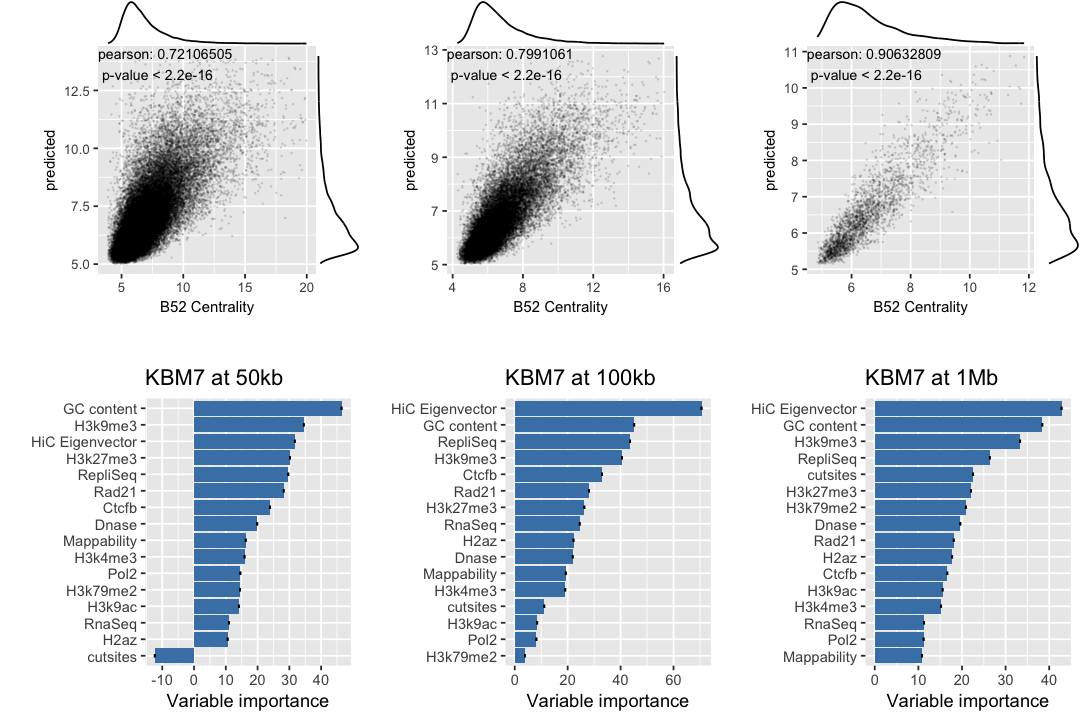

In [20]:
myplots <- c(splots, bplots)
length(myplots)
options(repr.plot.width=9, repr.plot.height=6)
g <- grid.arrange(grobs=myplots, nrow=2)


GC content and HiC compartment are important predictors for centrality.  This makes sense since these two features are strongly correlated.  The cutsite density has a negative variable importance.  It is difficult to say anything more about centrality except that it corresponds with open or active chromatin with high GC content.  At this resolution and from this data, we cannot say that centrality means something is more central to the nucleus versus just a representation of more open chromatin.  Things could have a high centrality simply because there are more DNase peaks or higher GC, for example.  

# Correlation of centrality with various features

## At 50kb resolution

In [21]:
fdat <- read.table("data/k562_50kb_features_v3.txt", header=T)
gdat <- read.table("data/B52.10-on.estimated.50kb.txt", header=T)

In [22]:
myplots=c()
for (i in seq(5,ncol(fdat))){
    p <- my_scatter_plot(x=fdat[,i], y=gdat$prob_g, quantile=TRUE, 
                    myylab="Prob_g", myxlab=fixlabels(colnames(fdat)[i]))
    myplots=c(myplots, list(p))
}

Warning message:
“Removed 383 rows containing missing values (geom_point).”Warning message:
“Removed 411 rows containing missing values (geom_point).”Warning message:
“Removed 436 rows containing missing values (geom_point).”Warning message:
“Removed 437 rows containing missing values (geom_point).”Warning message:
“Removed 436 rows containing missing values (geom_point).”Warning message:
“Removed 399 rows containing missing values (geom_point).”Warning message:
“Removed 399 rows containing missing values (geom_point).”Warning message:
“Removed 398 rows containing missing values (geom_point).”Warning message:
“Removed 394 rows containing missing values (geom_point).”Warning message:
“Removed 397 rows containing missing values (geom_point).”Warning message:
“Removed 396 rows containing missing values (geom_point).”Warning message:
“Removed 434 rows containing missing values (geom_point).”Warning message:
“Removed 384 rows containing missing values (geom_point).”Warning message:
“Removed

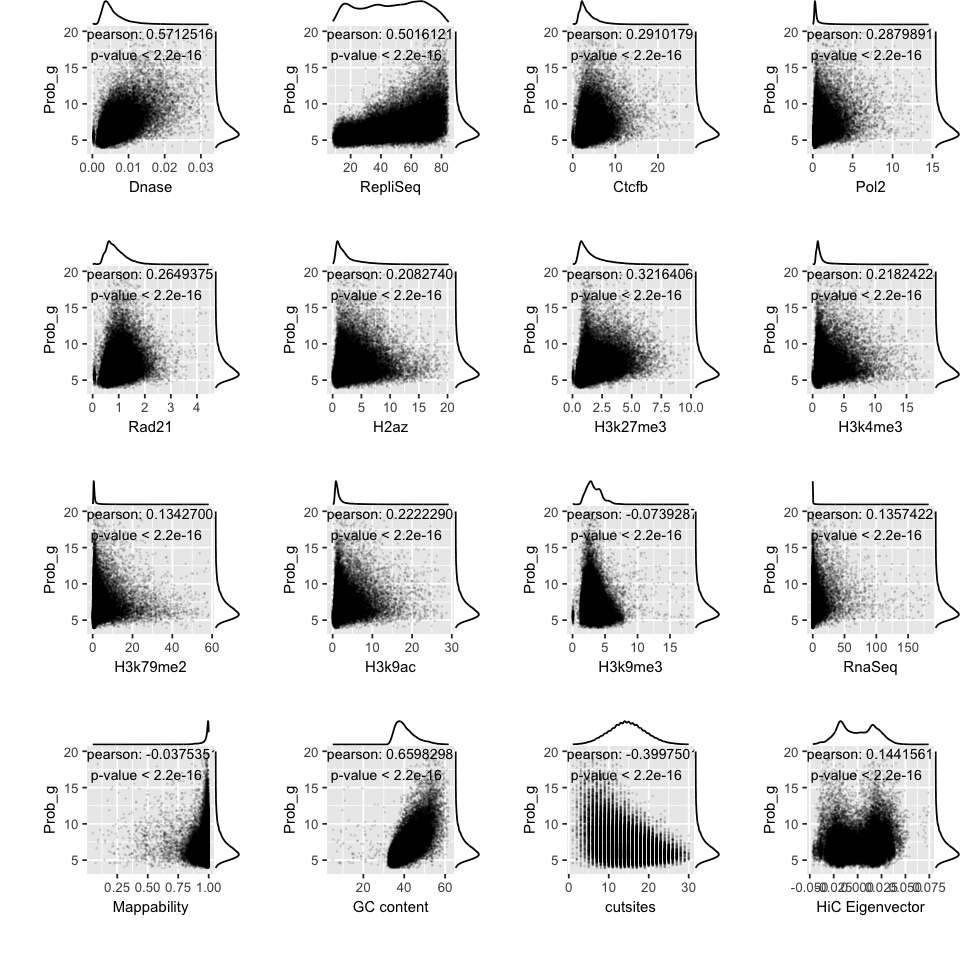

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
g <- grid.arrange(grobs=myplots, ncol=4)
ggsave(file="B52_probg_feat3_scatters_50kb.png", path=figdir, plot=g, width=9, height=9, units="in")

## At 100kb resolution

In [24]:
fdat <- read.table("data/k562_100kb_features_v3.txt", header=T)
gdat <- read.table("data/B52.10-on.estimated.100kb.txt", header=T)

In [25]:
myplots=c()
for (i in seq(5,ncol(fdat))){
    p <- my_scatter_plot(x=fdat[,i], y=gdat$prob_g, quantile=TRUE, 
                    myylab="Prob_g", myxlab=fixlabels(colnames(fdat)[i]))
    myplots=c(myplots, list(p))
}

Warning message:
“Removed 98 rows containing missing values (geom_point).”Warning message:
“Removed 111 rows containing missing values (geom_point).”Warning message:
“Removed 104 rows containing missing values (geom_point).”Warning message:
“Removed 95 rows containing missing values (geom_point).”Warning message:
“Removed 96 rows containing missing values (geom_point).”Warning message:
“Removed 115 rows containing missing values (geom_point).”Warning message:
“Removed 114 rows containing missing values (geom_point).”Warning message:
“Removed 114 rows containing missing values (geom_point).”Warning message:
“Removed 114 rows containing missing values (geom_point).”Warning message:
“Removed 115 rows containing missing values (geom_point).”Warning message:
“Removed 115 rows containing missing values (geom_point).”Warning message:
“Removed 120 rows containing missing values (geom_point).”Warning message:
“Removed 100 rows containing missing values (geom_point).”Warning message:
“Removed 11

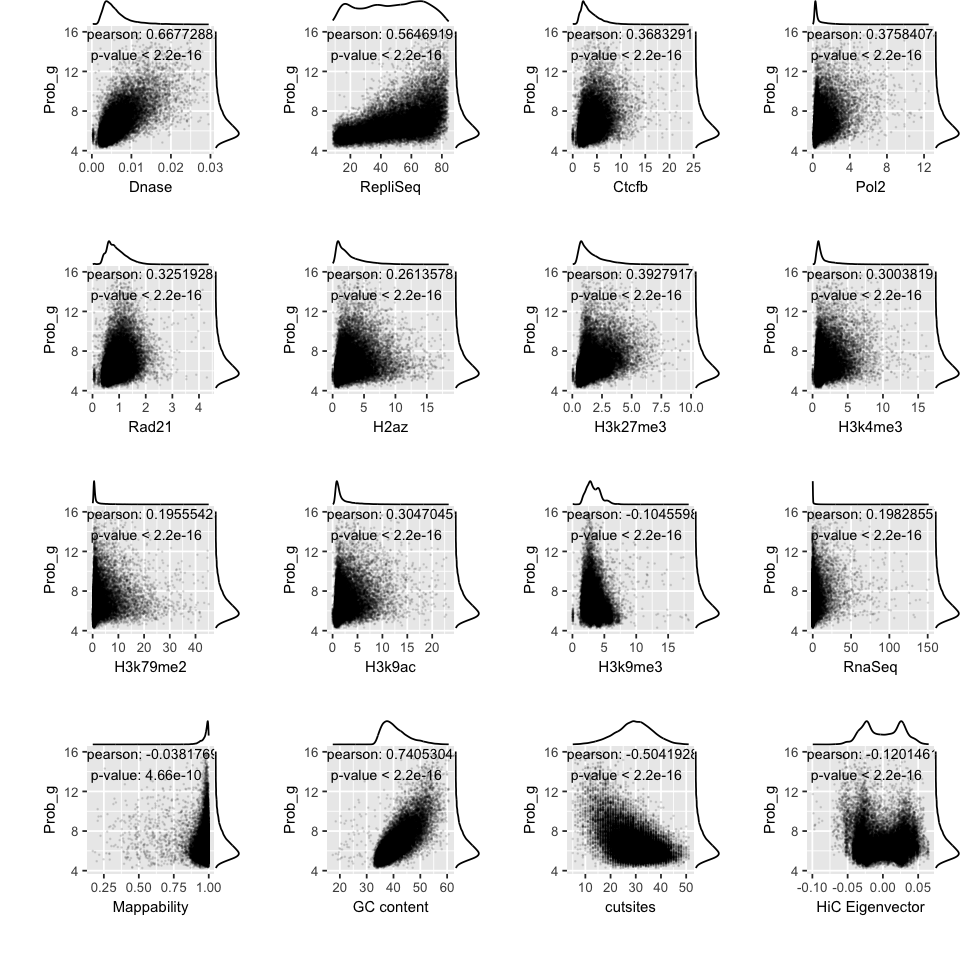

In [26]:
options(repr.plot.width=8, repr.plot.height=8)
g <- grid.arrange(grobs=myplots, ncol=4)
ggsave(file="B52_probg_feat3_scatters_100kb.png", path=figdir, plot=g, width=9, height=9, units="in")

## At 1MB Resolution

In [27]:
fdat <- read.table("data/k562_1Mb_features_v3.txt", header=T)
gdat <- read.table("data/B52.10-on.estimated.1Mb.txt", header=T)

In [28]:
myplots=c()
for (i in seq(5,ncol(fdat))){
    p <- my_scatter_plot(x=fdat[,i], y=gdat$prob_g, quantile=TRUE, 
                    myylab="Prob_g", myxlab=fixlabels(colnames(fdat)[i]))
    myplots=c(myplots, list(p))
}

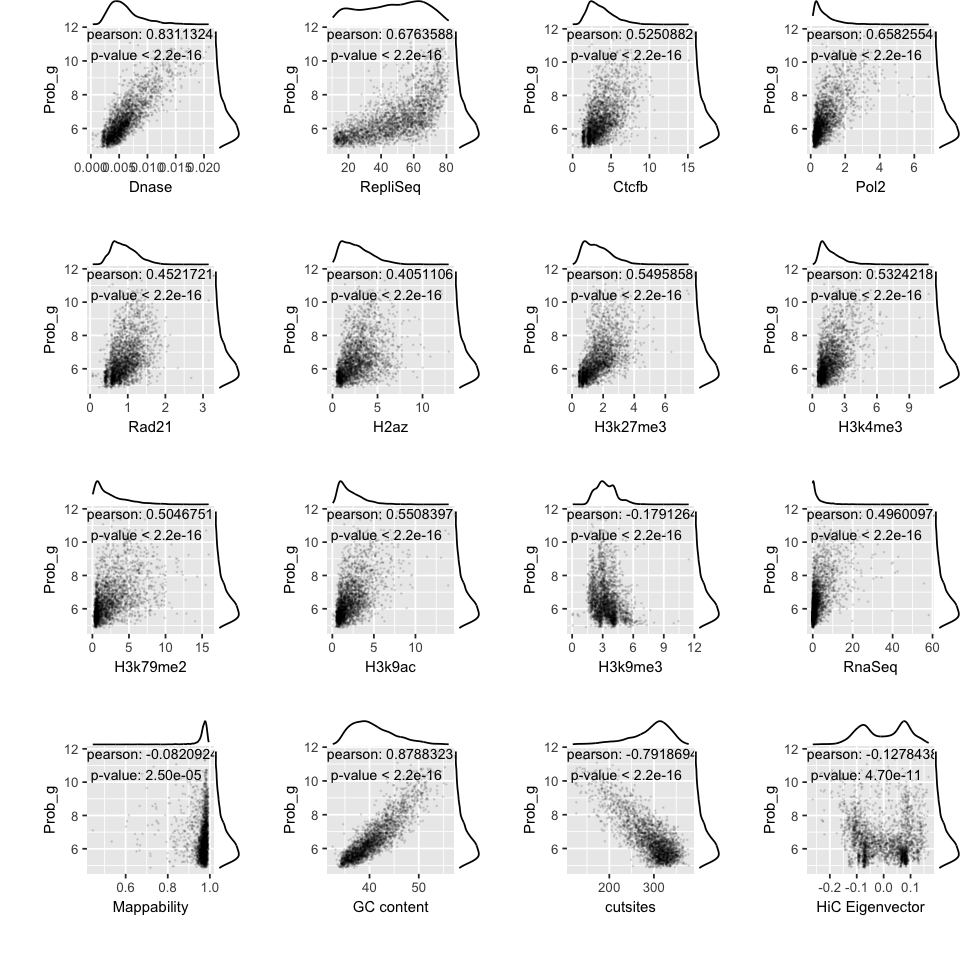

In [29]:
options(repr.plot.width=8, repr.plot.height=8)
g <- grid.arrange(grobs=myplots, ncol=4)
ggsave(file="B52_probg_feat3_scatters_1Mb.png", path=figdir, plot=g, width=9, height=9, units="in")

# Summary
## Conclusions
- The correlation of nearly every feature improves at lower resolution (1Mb) compared to the low resolution (50kb)
- Centrality is correlated with HiC eigenvector (A vs B compartments), and also with DNase, GC content, and is anticorrelated with the number of cutsites.
- In this analysis I've used K562 features to model data for KBM7 because there isn't much ENCODE data for KBM7.  However, K562 is a erythroleukemia cell line and resembles undifferentiated granulocytes (white blood cells) and erythrocytes (red blood cells). KBM-7 cells are from a CML, which is a disease of granulocytes (white blood cells).  

## Next steps
- Generate a Random forest using features from KBM-7 cells, which will have to be collected from various sources- is there data in the Roadmap for white blood cells? 
- I don't think we can draw any conclusions other than that centrality is associated with "open" or active chromatin at Mb resolution.  Maybe that is the only conclusion we need to draw.

## Open questions
- What question do we hope to answer from generating random forest models?
- Why is centrality negatively correlated with cutsite density? 